# AHCCD (Adjusted and Homogenized Canadian Climate Data)

### The following is an exercise in formating, combining, plotting and interpolating the adjusted and homogenized canadian climate data for multiple climate variable measurements taken at stations across Canada since, in some cases, as early as 1840.

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import PolynomialFeatures


### Processing AHCCD sttation data and combining into a single csv file:

In [ ]:
import pandas as pd
import os
import re

def remove_whitespace_before_year(file_path):#removing whitespace before the word 'year' in the txt file
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        lines = file.readlines()
        
        if lines[2].lstrip().startswith('Year'):#check if whitespace before year
        lines[2] = lines[2].lstrip()  #remove tthe whitespace
    
    with open(file_path, 'w', encoding='ISO-8859-1') as file:#rewrite the file
        file.writelines(lines)

for folder_path in input_folders:#removing whitespace across files
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            remove_whitespace_before_year(file_path)

def read_station_metadata(metadata_file):#loading the sations metadata to pull coordiinate values and names etc...
    metadata = pd.read_csv(metadata_file, dtype={'StnId': str})#clarifying the station name is a string
    return metadata[['StnId', 'Station name', 'Lat(deg)', 'Long(deg)', 'Elev(m)']]

def process_file(file_path, var_name, metadata):
    with open(file_path, 'r', encoding='ISO-8859-1') as f:#open given file and read lines
        lines = f.readlines()

    station_id = lines[0].split(',')[0].strip()#take station ID from firs cell in csv and make it a string to match with metadata
    station_id = str(station_id)
    
    data = pd.read_csv(#reading data with removed headers
        file_path,
        skiprows=[0, 1, 2, 3],
        header=None,
        encoding='ISO-8859-1',
        on_bad_lines='skip'
    )
    
    selected_columns = [0] + list(range(1, 34, 2))#selecting columns to extract data from
    data = data.iloc[:, selected_columns]
    print(data)#checking dataframe makes sense
    
    month_columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
                     'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Annual', 'Winter', 'Spring', 'Summer', 'Autumn']
    data.columns = month_columns#rename columns according to months etc
    
    data.replace(-9999.9, pd.NA, inplace=True)#replace 9999.9 with NaN
    
    data['Station ID'] = station_id #adding columns
    data['Value Type'] = var_name
    
    # Lookup station information from metadata
    station_info = metadata[metadata['StnId'] == station_id]#finding station metadata by station ID
    if station_info.empty:
        print(f"No metadata found for station ID {station_id}")
        return pd.DataFrame()
    
    station_info = station_info.iloc[0]#adding columns from metadata
    data['Station'] = station_info['Station name']
    data['Latitude'] = station_info['Lat(deg)']
    data['Longitude'] = station_info['Long(deg)']
    data['Elevation'] = station_info['Elev(m)']

    return data

def collect_data(folder_path, var_name, metadata): #performs all previous functions and collects data from separate files
    all_data = pd.DataFrame()
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            print(f"Processing file: {file_path}")
            station_data = process_file(file_path, var_name, metadata)
            all_data = pd.concat([all_data, station_data], ignore_index=True)
    
    return all_data

def save_to_csv(output_path, folder_paths, folder_names, metadata): #saving data to csv file
    all_data = pd.DataFrame()
    
    for folder_path, folder_name in zip(folder_paths, folder_names):
        folder_data = collect_data(folder_path, folder_name, metadata)
        all_data = pd.concat([all_data, folder_data], ignore_index=True)
    
    final_columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', #setting columns to appear in final csv file (filters through collected data)
                     'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Annual', 'Winter', 
                     'Spring', 'Summer', 'Autumn', 'Station', 'Latitude', 
                     'Longitude', 'Elevation', 'Value Type']
    all_data = all_data[final_columns]
    
    all_data.to_csv(output_path, index=False)
    print(f"Data saved to {output_path}")

metadata_file = '/Users/maxMax/Desktop/Datasets/AHCCD_STATIONS.csv'
input_folders = [
    '/Users/maxMax/Desktop/Datasets/AHCCD/Homog_monthly_min_temp_Gen3', 
    '/Users/maxMax/Desktop/Datasets/AHCCD/Homog_monthly_max_temp_Gen3', 
    '/Users/maxMax/Desktop/Datasets/AHCCD/Adj_monthly_snow', 
    '/Users/maxMax/Desktop/Datasets/AHCCD/Adj_monthly_rain',
    '/Users/maxMax/Desktop/Datasets/AHCCD/Adj_monthly_total_prec', 
    '/Users/maxMax/Desktop/Datasets/AHCCD/Homog_monthly_sea_level_pressure',
    '/Users/maxMax/Desktop/Datasets/AHCCD/Homog_monthly_station_pressure', 
    '/Users/maxMax/Desktop/Datasets/AHCCD/Homog_monthly_wind_speed', 
    '/Users/maxMax/Desktop/Datasets/AHCCD/Homog_monthly_mean_temp_Gen3'
]
folder_names = [
    'Min Temperature', 'Max Temperature', 'Snow', 'Rain',
    'Total Precipitation', 'Sea Level Pressure', 'Station Pressure', 'Mean Wind Speed', 'Mean Temperature'
]
output_csv = 'AHCCD.csv'

station_metadata = read_station_metadata(metadata_file)
save_to_csv(output_csv, input_folders, folder_names, station_metadata)


### Now need to confine the data to the select region in Eastern Canada we want to look at:

In [ ]:
import pandas as pd

data = pd.read_csv('AHCCD.csv')

lat_min, lat_max = 40, 63
lon_min, lon_max = -81, -50

confined_data = data[(data['Latitude'] >= lat_min) & (data['Latitude'] <= lat_max) &
                     (data['Longitude'] >= lon_min) & (data['Longitude'] <= lon_max)]

confined_data.to_csv('AHCCD_CONFINED.csv', index=False)

print("Filtered data saved to 'AHCCD_CONFINED.csv'")


### Plotting all stations on map:

/var/folders/h5/wr1_5h5s2sd3jw2htzn509v00000gp/T/ipykernel_44193/319809402.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


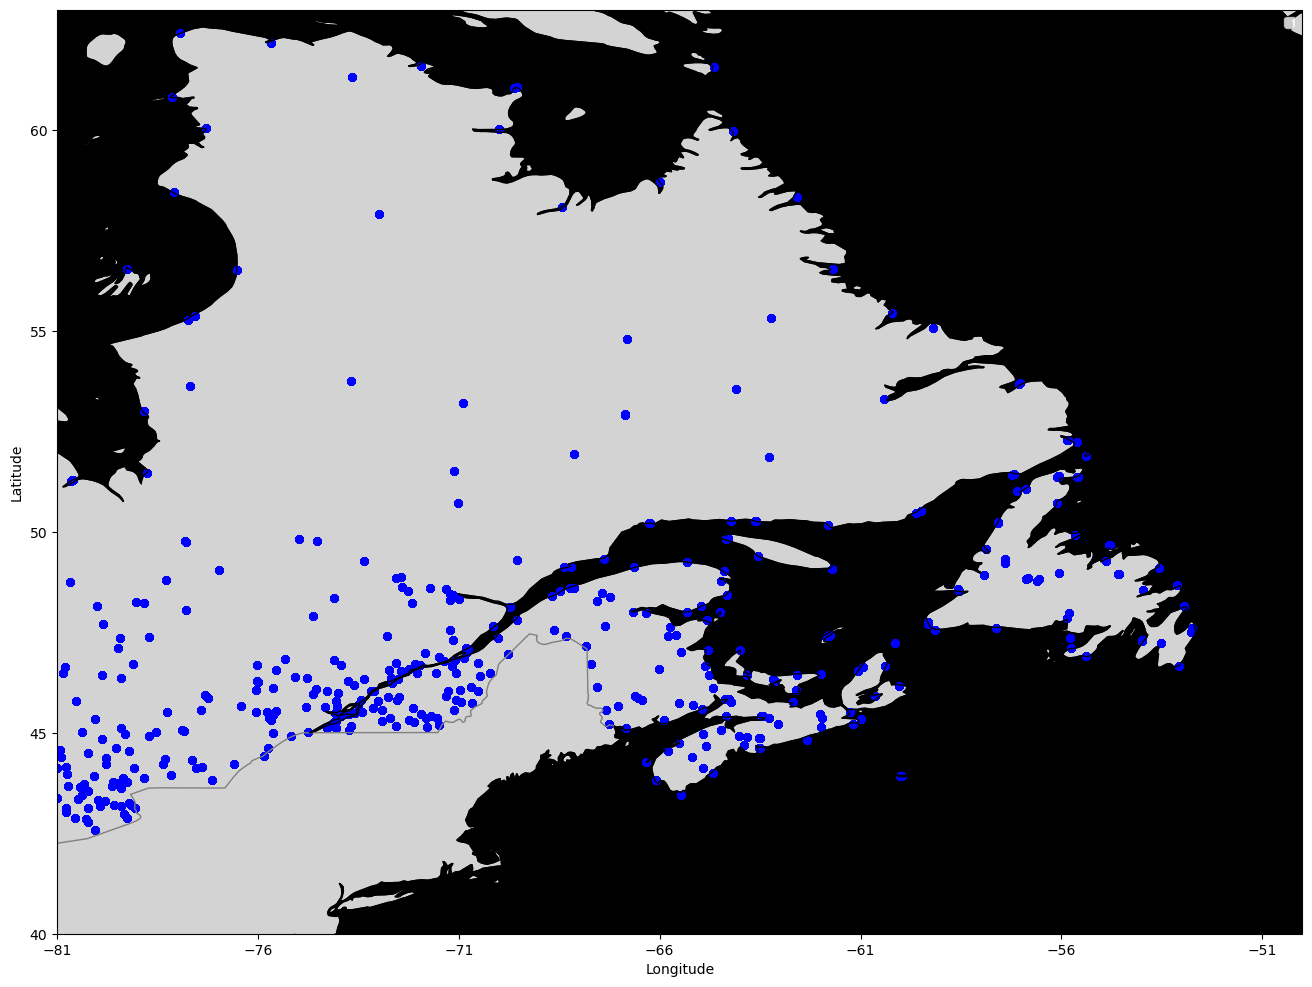

In [126]:
ecws_data_test = pd.read_csv('AHCCD_CONFINED.csv')

ecws_lon46 = ecws_data_test['Longitude']
ecws_lat46 = ecws_data_test['Latitude']

lat_min, lat_max = 40, 63
lon_min, lon_max = -81, -50

fig, ax = plt.subplots(figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='gray')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.add_feature(cfeature.LAND, color='lightgrey')
ax.add_feature(cfeature.OCEAN, color='black')
ax.set_xticks(np.arange(lon_min, lon_max + 1, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())

plt.scatter(ecws_lon46, ecws_lat46, color='blue', s=25, marker='o', transform=ccrs.PlateCarree())

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.show()


### Plotting stations with data available for individual vaariables:

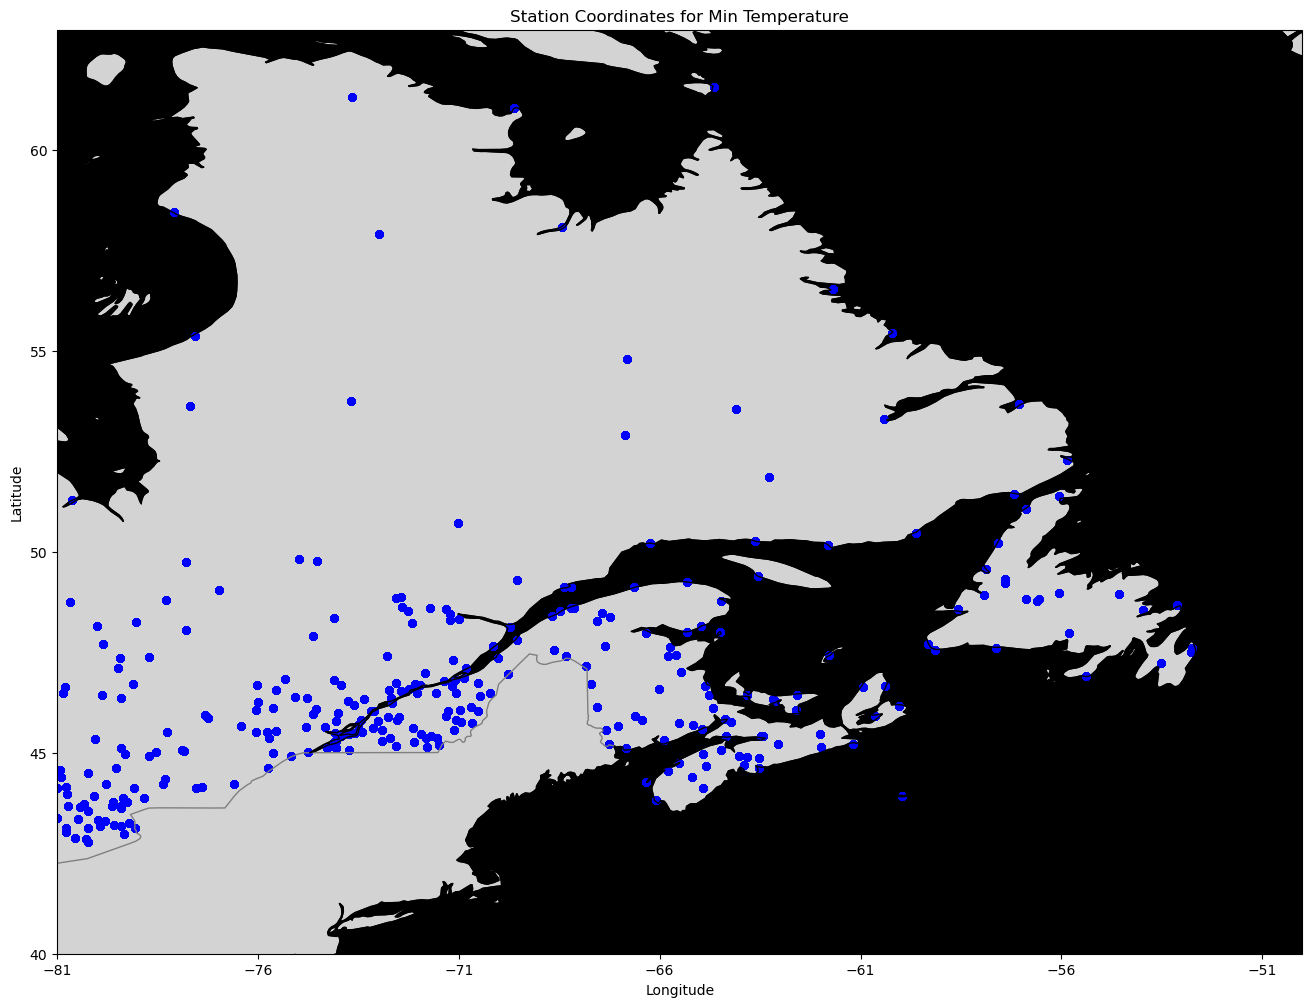

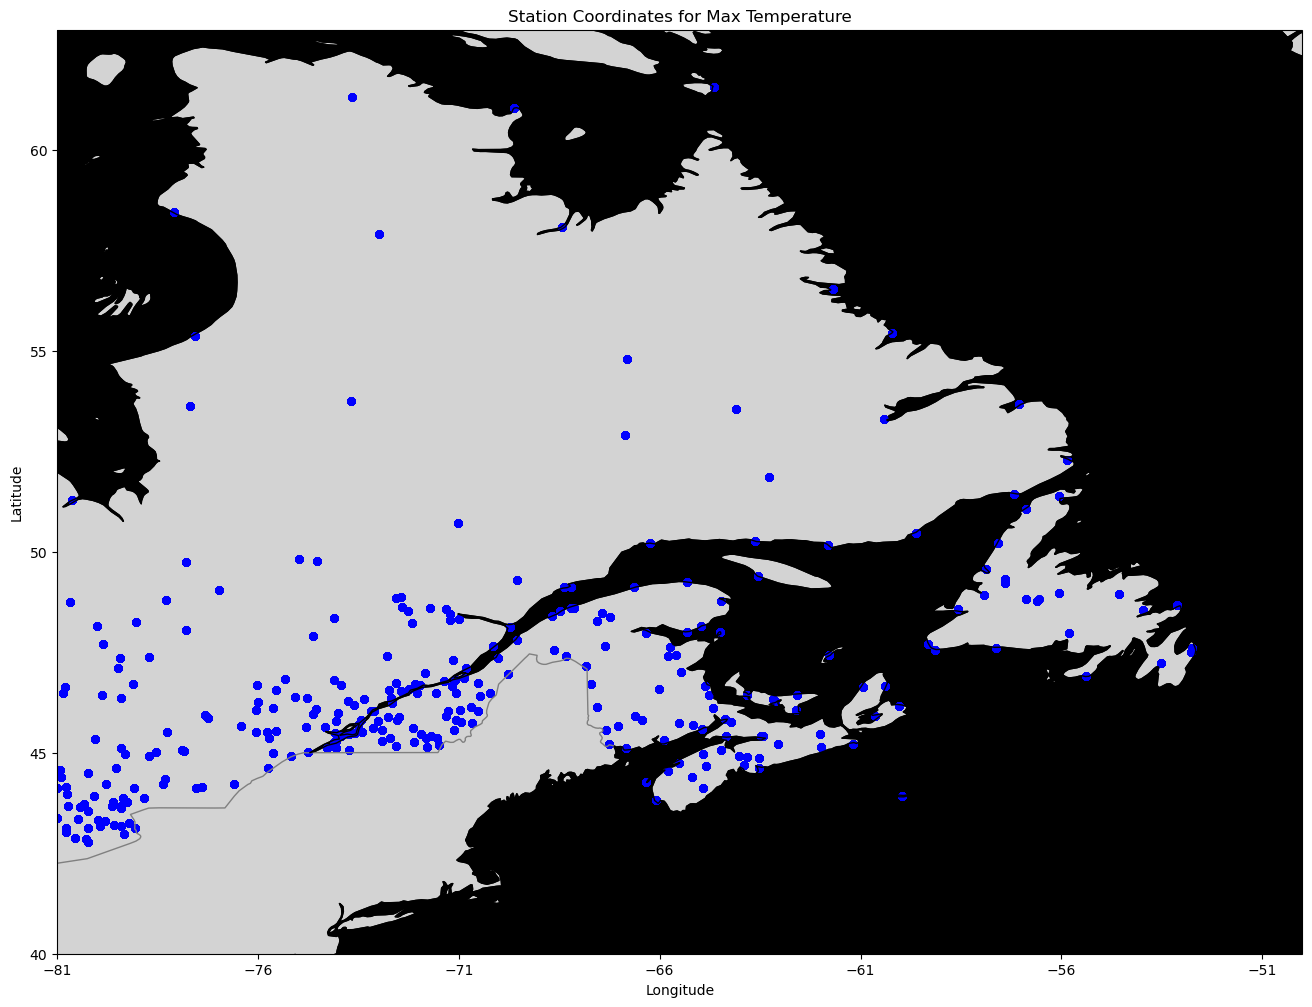

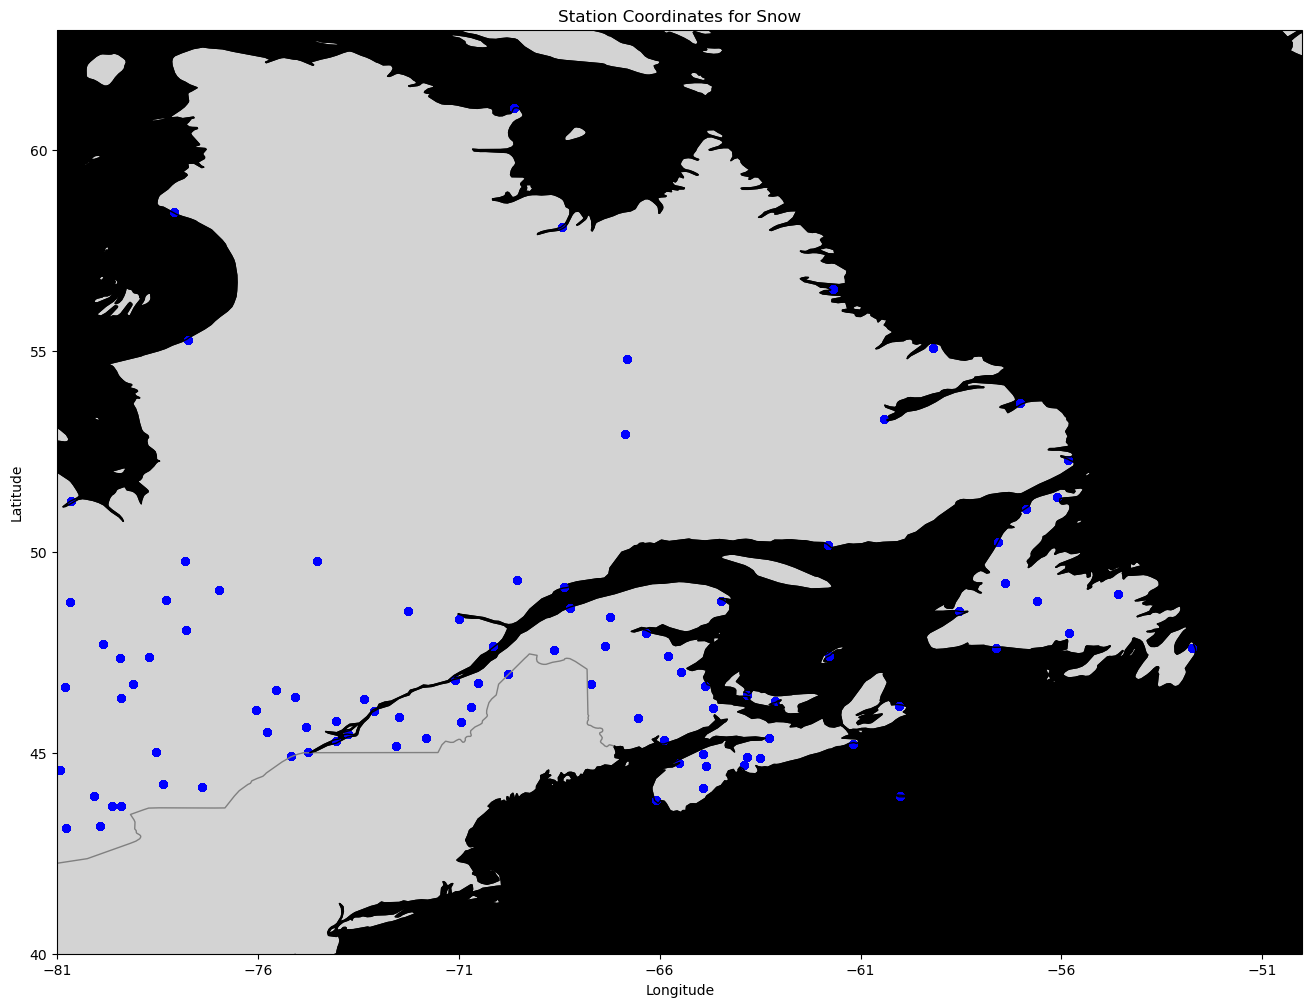

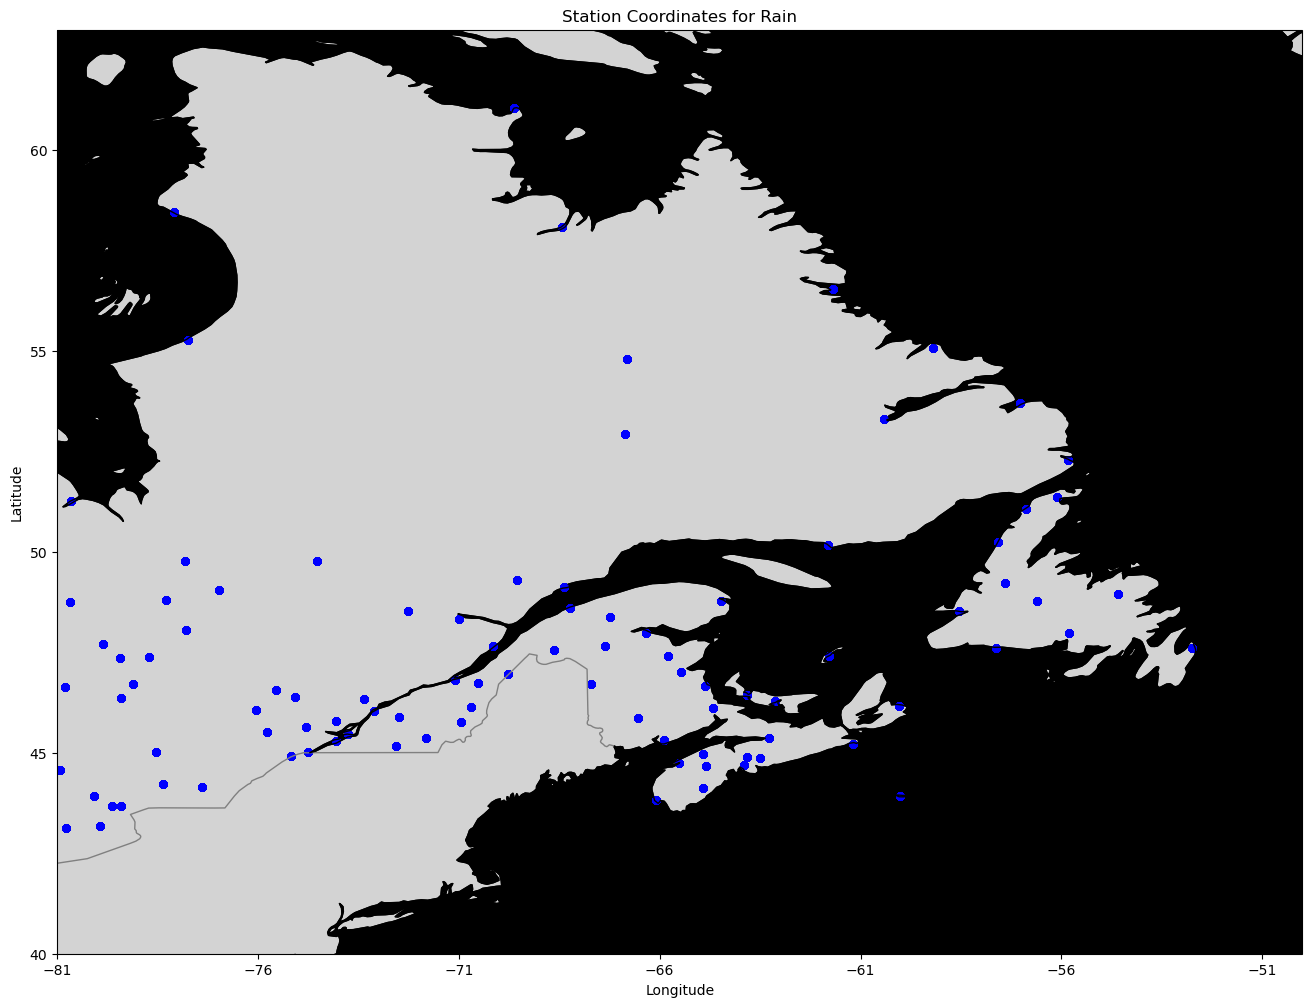

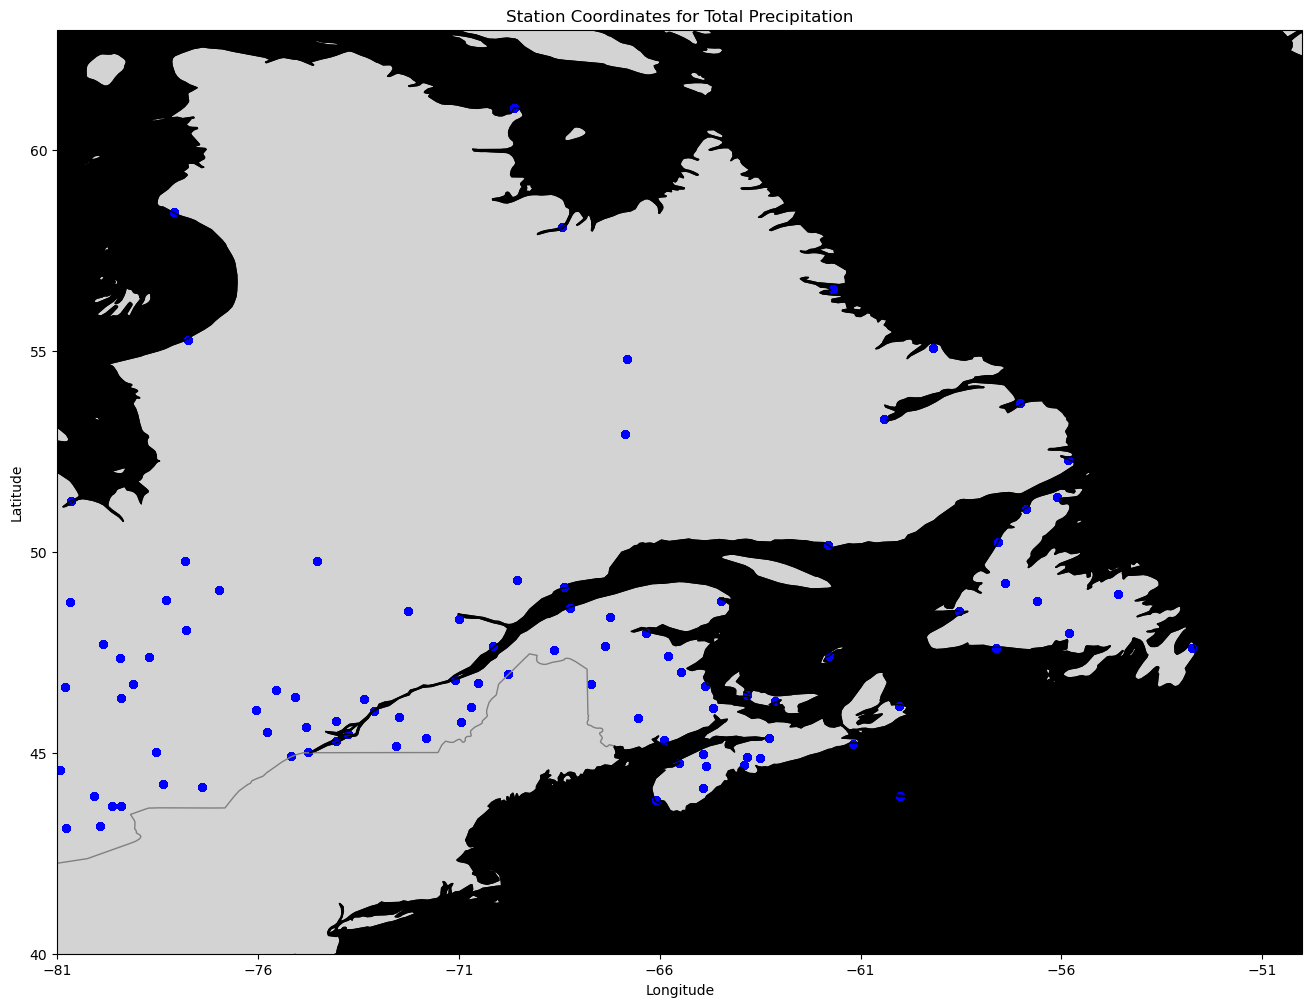

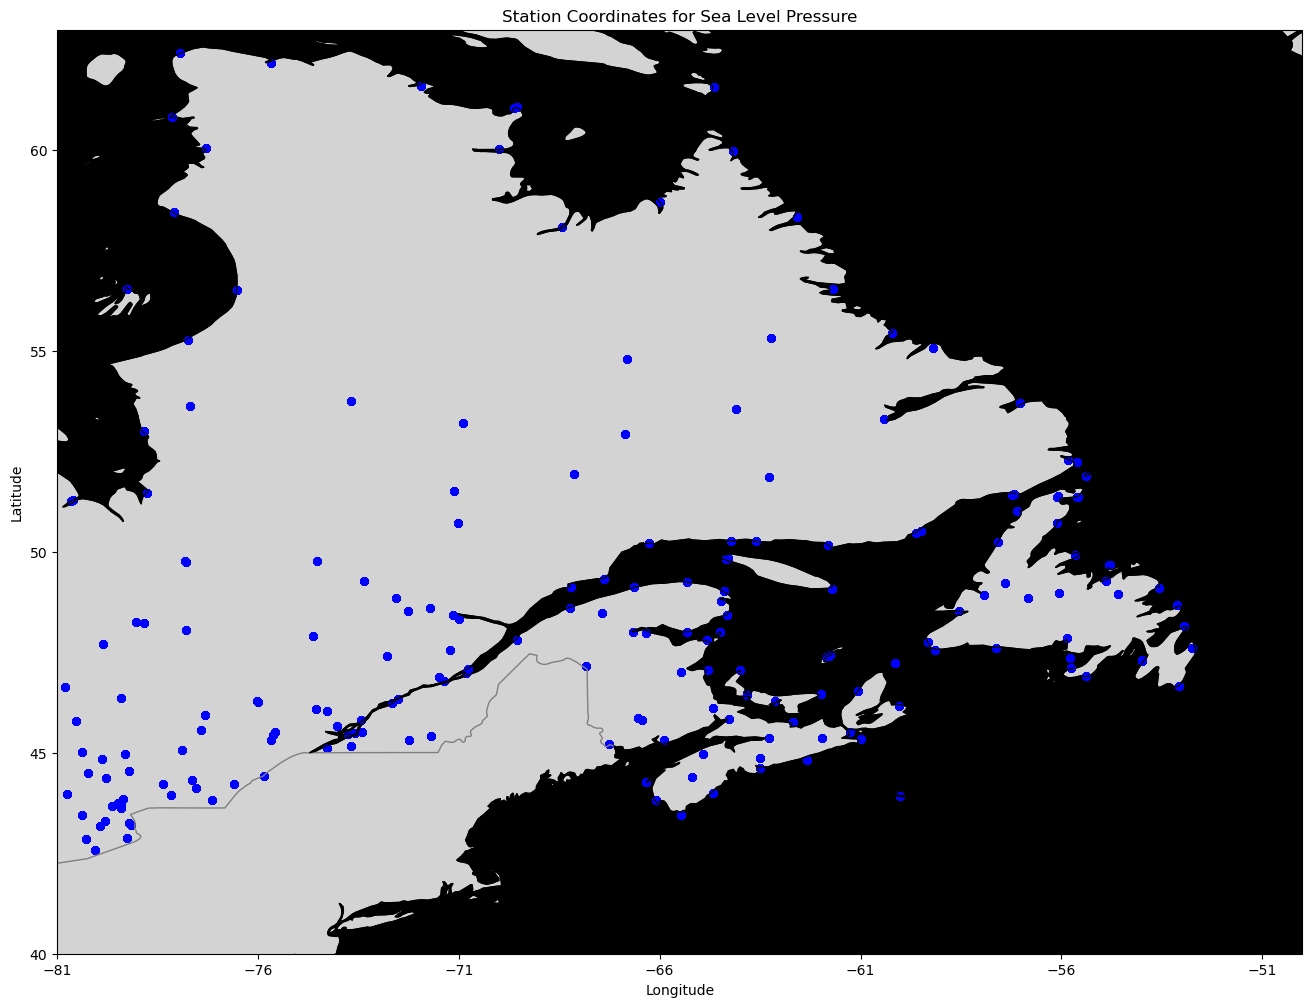

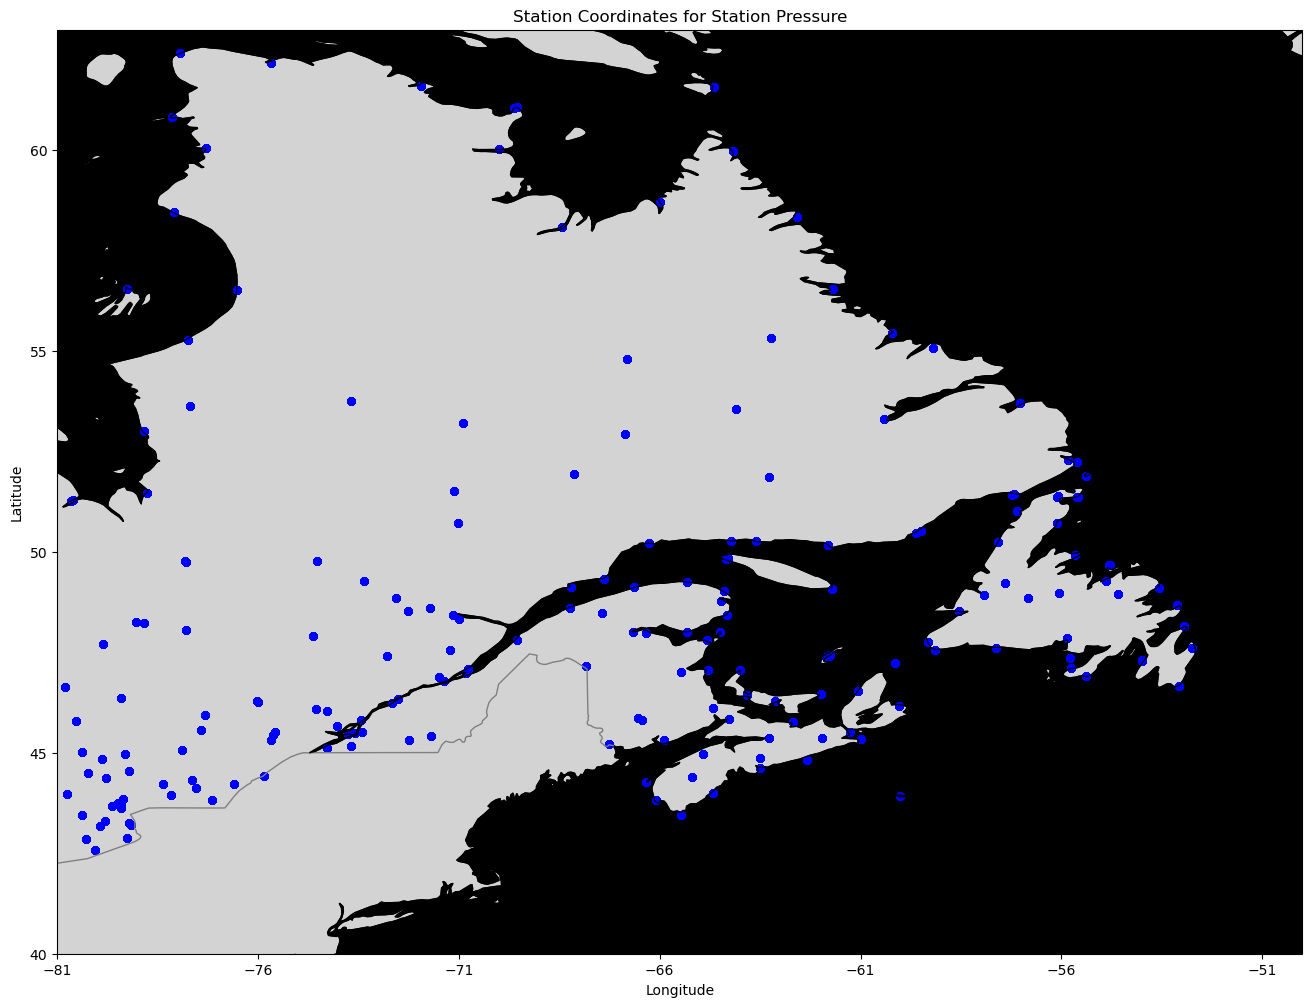

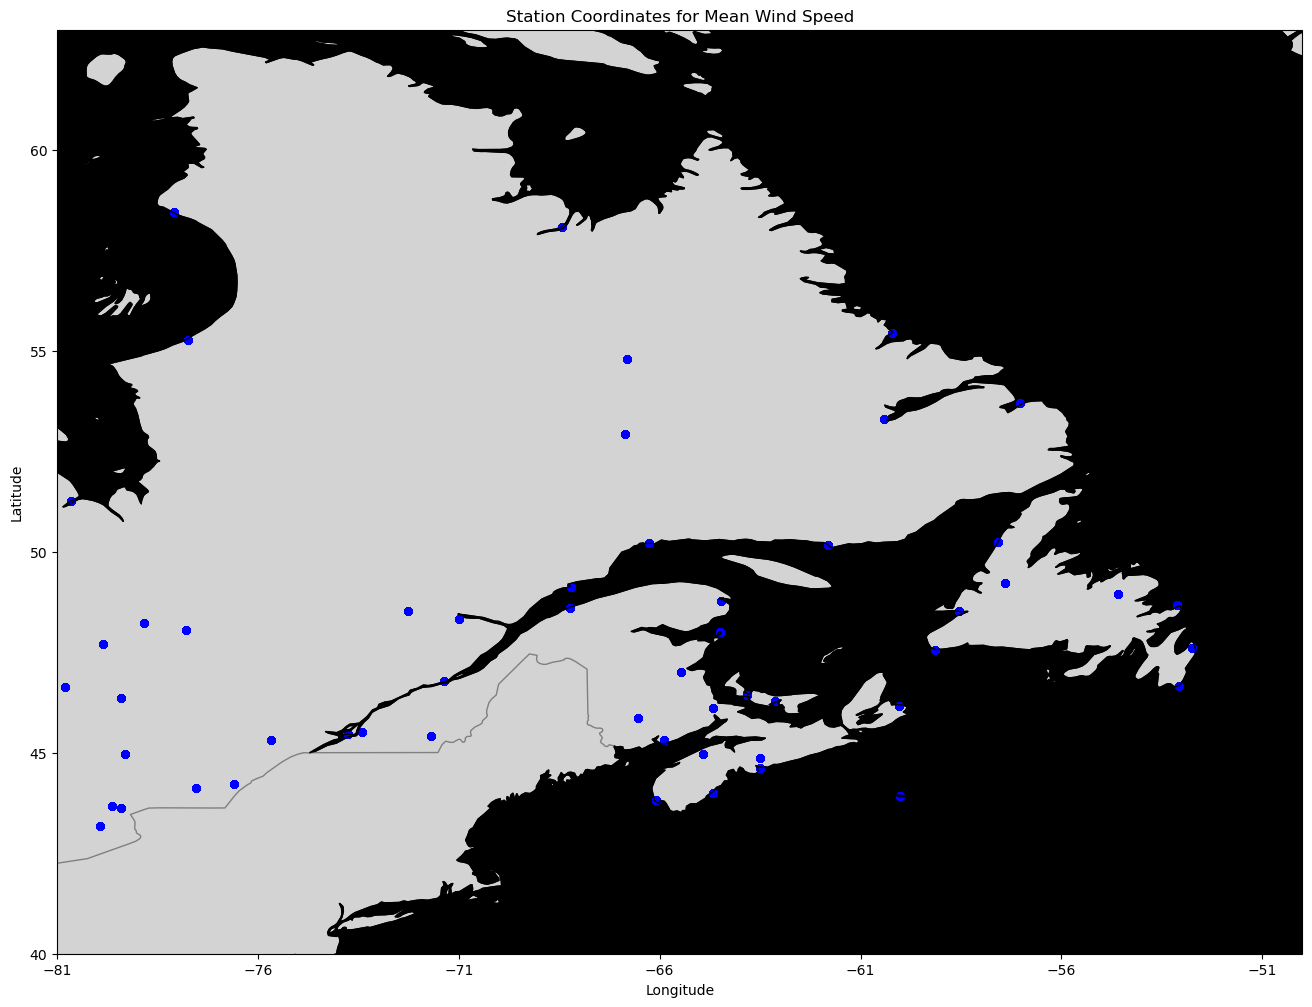

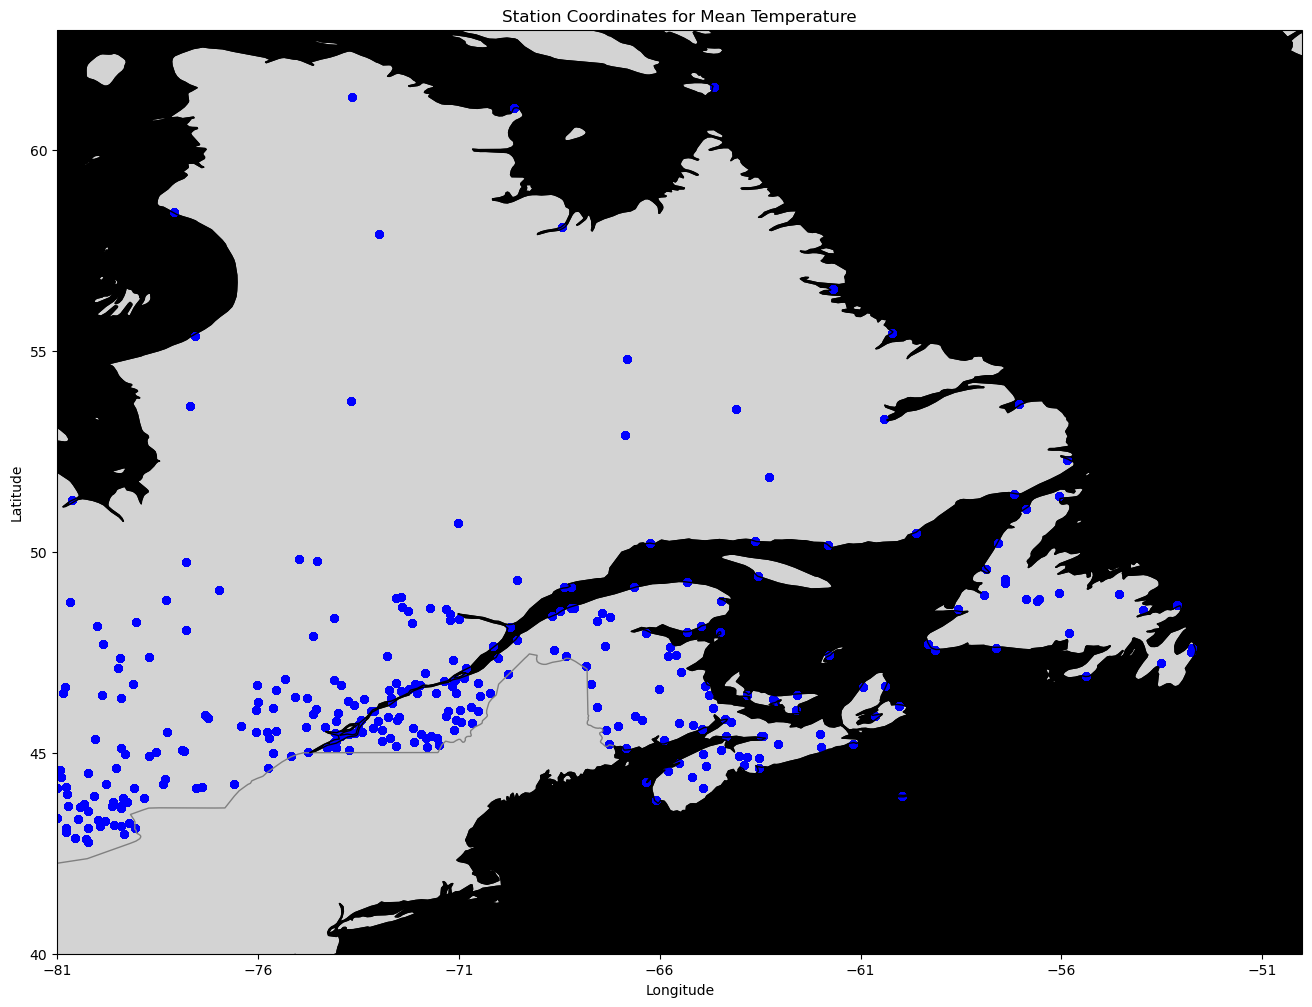

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

ecws_data_test = pd.read_csv('AHCCD_CONFINED.csv')

lat_min, lat_max = 40, 63
lon_min, lon_max = -81, -50

variable_types = ecws_data_test['Value Type'].unique()#get unique variable types

for var_type in variable_types: #loop through each variable type and plot
    data_subset = ecws_data_test[ecws_data_test['Value Type'] == var_type] #filter data for specified variable type
    ecws_lon = data_subset['Longitude']
    ecws_lat = data_subset['Latitude']
    
    fig, ax = plt.subplots(figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()})#map
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='gray')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.add_feature(cfeature.OCEAN, color='black')
    ax.set_xticks(np.arange(lon_min, lon_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
    
    plt.scatter(ecws_lon, ecws_lat, color='blue', s=25, marker='o', transform=ccrs.PlateCarree(), label=var_type)#scatter plot stattions
    
    plt.title(f'Station Coordinates for {var_type}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.show()

### Ploting variable data with regression:

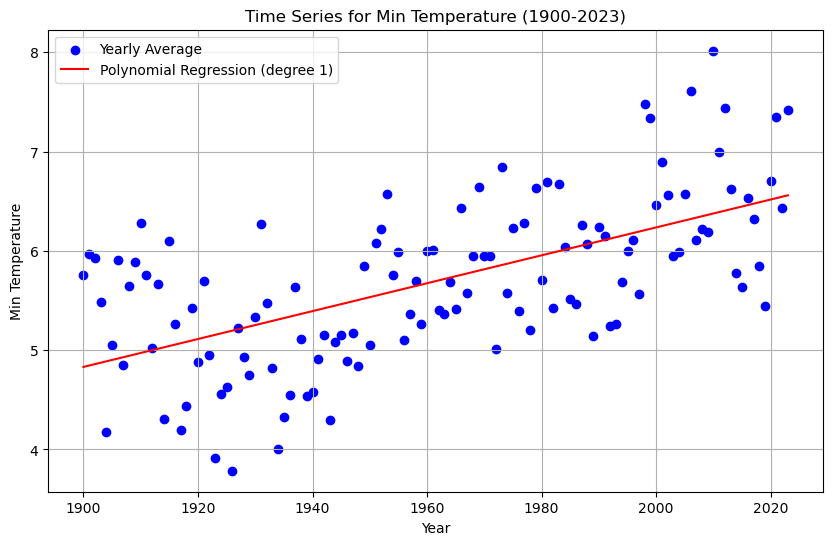

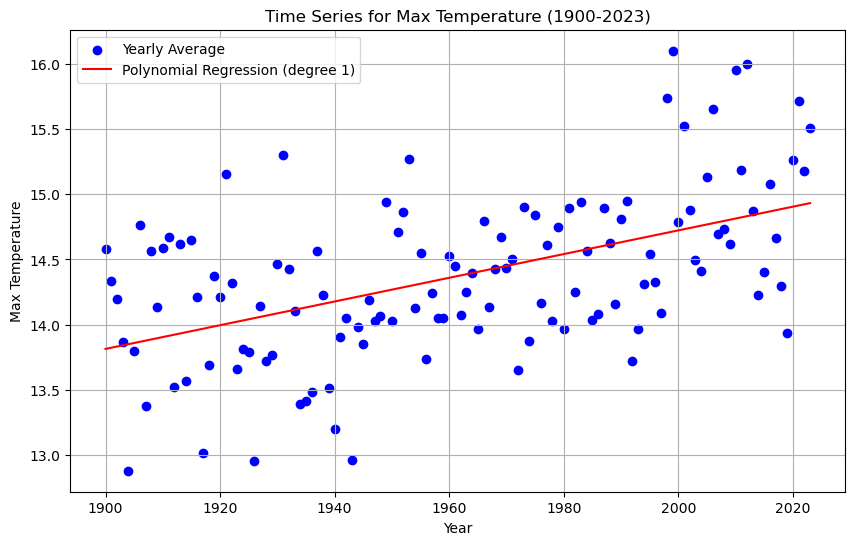

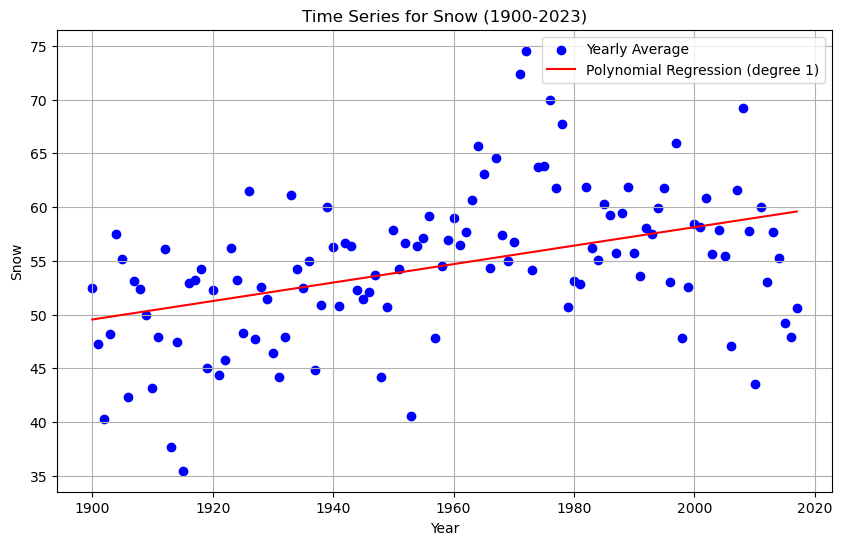

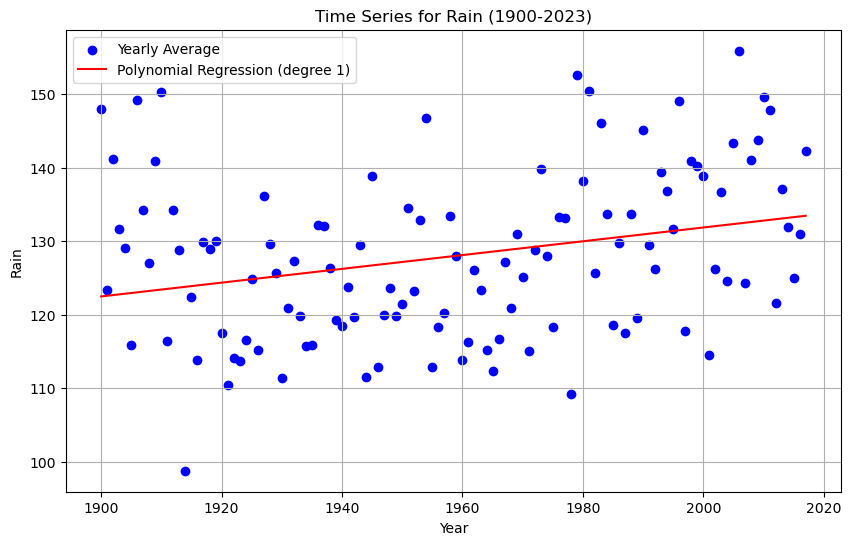

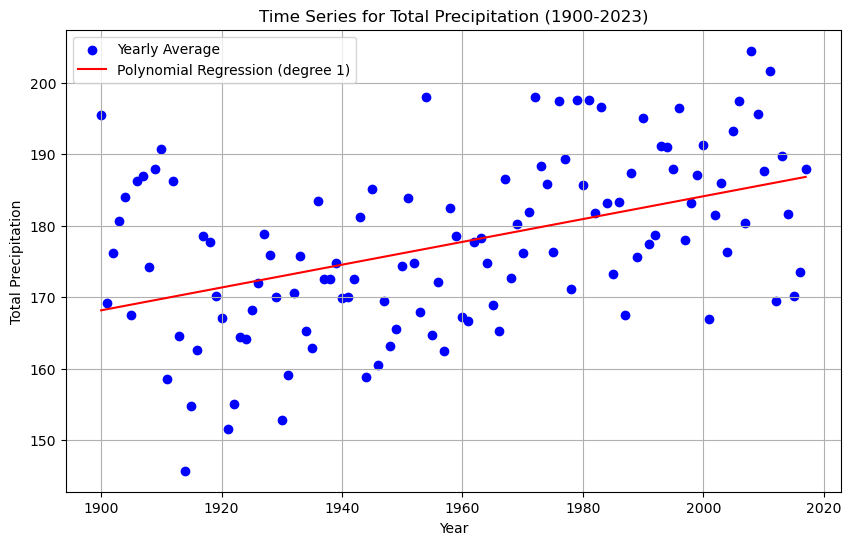

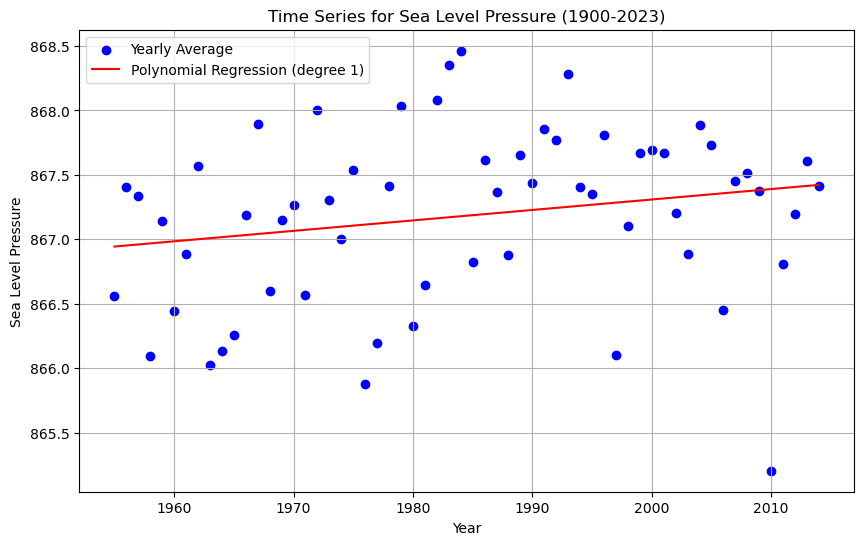

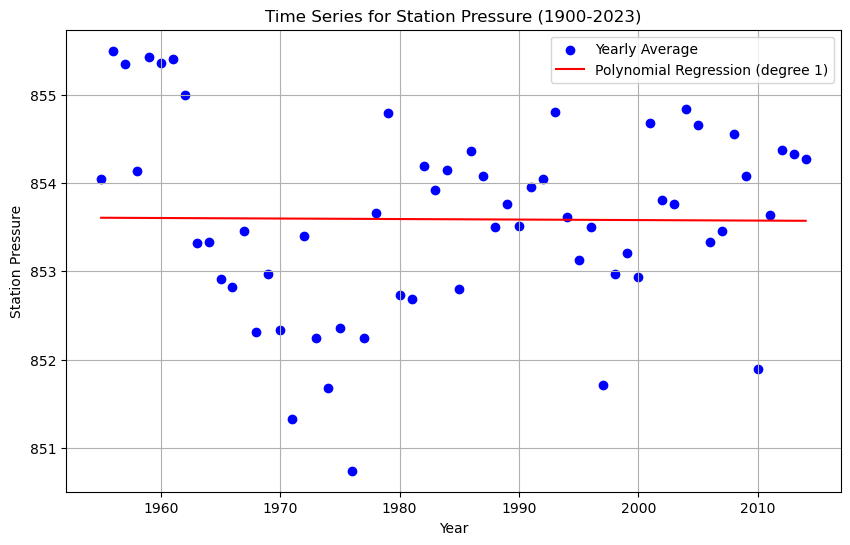

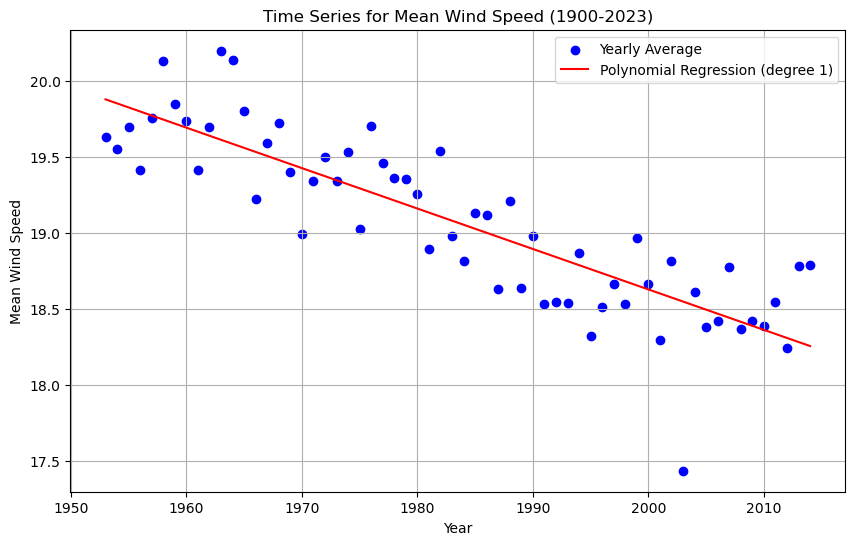

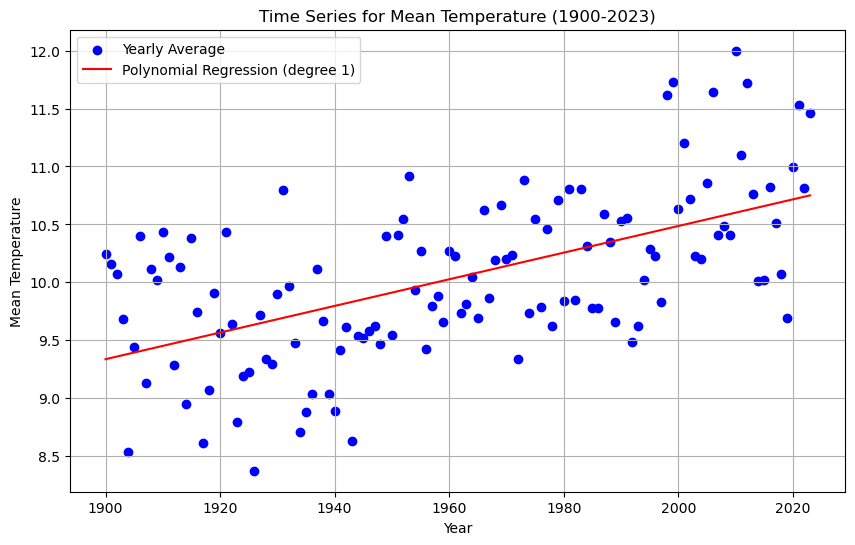

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

ecws_data = pd.read_csv('AHCCD_CONFINED.csv')
ecws_data['Year'] = pd.to_numeric(ecws_data['Year'], errors='coerce')#making sure year column is numeric (not string)
ecws_data = ecws_data.dropna(subset=['Year'])#dropping rows with NaN year

start_year = 1900
end_year = 2023

variable_types = ecws_data['Value Type'].unique()#list variable types

for var_type in variable_types:#create plot for each variable
    data_subset = ecws_data[ecws_data['Value Type'] == var_type]#filter for current type
    
    data_subset = data_subset[(data_subset['Year'] >= start_year) & (data_subset['Year'] <= end_year)]#filter for time span
    
    yearly_avg = data_subset.groupby('Year').mean(numeric_only=True).reset_index()#group by year and caluclate average

    X = yearly_avg['Year'].values.reshape(-1, 1)#extract year and average value across all stations for regression
    y = yearly_avg.iloc[:, 1:].mean(axis=1).values

    degree = 1#regression
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)
    model_poly = LinearRegression()
    model_poly.fit(X_poly, y)
    y_poly_pred = model_poly.predict(X_poly)

    plt.figure(figsize=(10, 6))#plotting
    plt.scatter(yearly_avg['Year'], y, label='Yearly Average', color='blue', marker='o')
    plt.plot(yearly_avg['Year'], y_poly_pred, label=f'Polynomial Regression (degree {degree})', color='red', linestyle='-')
    plt.title(f'Time Series for {var_type} ({start_year}-{end_year})')
    plt.xlabel('Year')
    plt.ylabel(var_type)
    plt.legend()
    plt.grid()
    plt.show()

### An attempt at interpolating using 'Thin Plate' interpolaion:

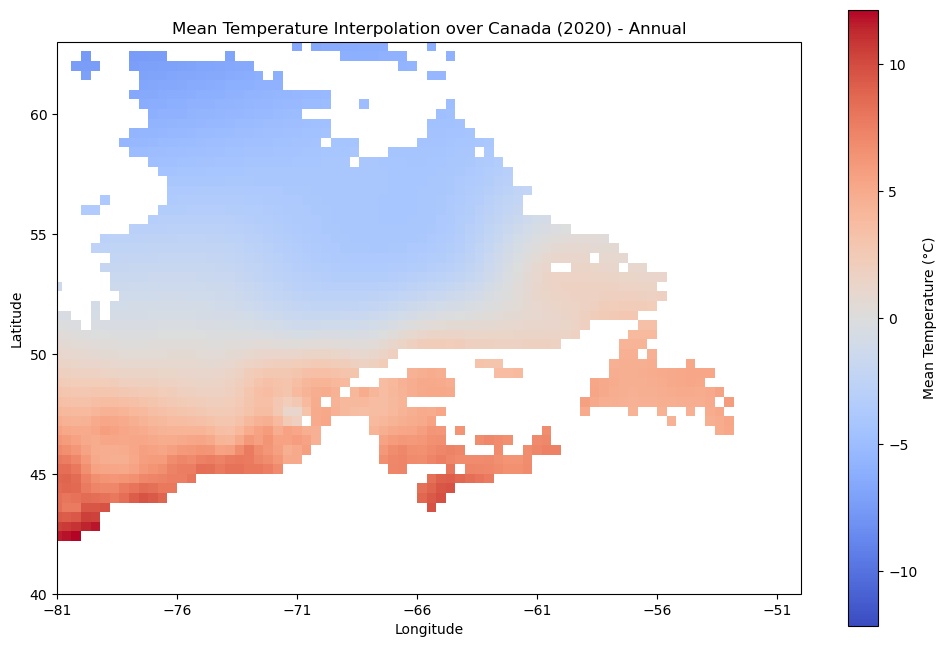

In [128]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import Rbf
from shapely.geometry import Point
import cartopy.io.shapereader as shpreader

ecws_data = pd.read_csv('AHCCD_CONFINED.csv')

def plot_interpolated_data(value_type, year, columns):
    data_subset = ecws_data[(ecws_data['Value Type'] == value_type) & (ecws_data['Year'] == year)]#filter for specified value type and year
    data_subset = data_subset.drop_duplicates(subset=['Longitude', 'Latitude'])#removing duplicate coordinates

    ecws_lon = data_subset['Longitude'].values#extract coordinates
    ecws_lat = data_subset['Latitude'].values
    mean_values = data_subset[columns].mean(axis=1).values#average over the temporal specification ("columns")

    valid_indices = ~np.isnan(mean_values)#remove rows where mean is NaN
    ecws_lon = ecws_lon[valid_indices]
    ecws_lat = ecws_lat[valid_indices]
    mean_values = mean_values[valid_indices]

    lat_min, lat_max = 40, 63 #defining grid boundaries and resolution
    lon_min, lon_max = -81, -50
    lat_res, lon_res = 0.4, 0.4

    latitudes = np.arange(lat_min, lat_max, lat_res)#create array of coordinates
    longitudes = np.arange(lon_min, lon_max, lon_res)
    grid_lon, grid_lat = np.meshgrid(longitudes, latitudes)#mesh coordinates to create grid

    rbf_interpolator = Rbf(ecws_lon, ecws_lat, mean_values, function='thin_plate')#performing interpolation and creating interpolater object
    interpolated_grid = rbf_interpolator(grid_lon, grid_lat)#calling interpolater object and interpolating over given grid

    shape_reader = shpreader.natural_earth(resolution='50m', category='cultural', name='admin_0_countries')#accesses geometry of canada as specified resolution
    canada_shape = [record.geometry for record in shpreader.Reader(shape_reader).records() if record.attributes['NAME'] == 'Canada'][0]#iterates over each country’s record in the shapefile and filters for records and returns polygon of canada's shape

    mask = np.zeros(interpolated_grid.shape, dtype=bool)#masks data outside of canada
    for i in range(grid_lon.shape[0]):
        for j in range(grid_lon.shape[1]):#iterates through the 2D grid
            point = Point(grid_lon[i, j], grid_lat[i, j])#creates a shapely.geometry.Point object for the current grid point which represents the geographical location at for each cell in grid
            if not canada_shape.contains(point): #if point lies outside of defined canada shape, then masking is set to true
                mask[i, j] = True

    interpolated_grid = np.ma.array(interpolated_grid, mask=mask) #apply the dak to the inerpolated grid

    data_da = xr.DataArray(#create xarray data array from interpolated data and coords
        interpolated_grid,
        dims=("latitude", "longitude"),
        coords={"latitude": latitudes, "longitude": longitudes},
        name=f"{value_type}_interpolated"
    )
    data_da.attrs["description"] = f"{value_type} Interpolation over Canada (RBF Multiquadratic)"

    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()}) #option to plot with cartopy
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    #ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='gray')
    #ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    #ax.add_feature(cfeature.LAND, color='lightgrey')
    #ax.add_feature(cfeature.OCEAN, color='aqua')

    data_da.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': f'{value_type} (°C)'})#plotting intterpolated grid
    ax.set_xticks(np.arange(lon_min, lon_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"{value_type} Interpolation over Canada ({year}) - {', '.join(columns)}")
    #plt.scatter(ecws_lon, ecws_lat)#alllows for plotting of stations where data has been used for interpolation
    plt.show()


plot_interpolated_data('Mean Temperature', 2020, ['Annual'])



Yearly Average Pre-1990 Gradient (Slope): 0.010625
Yearly Average Pre-1990 Z-Score: 4.104950
Yearly Average Post-1990 Gradient (Slope): 0.020030
Yearly Average Post-1990 Z-Score: 1.588494


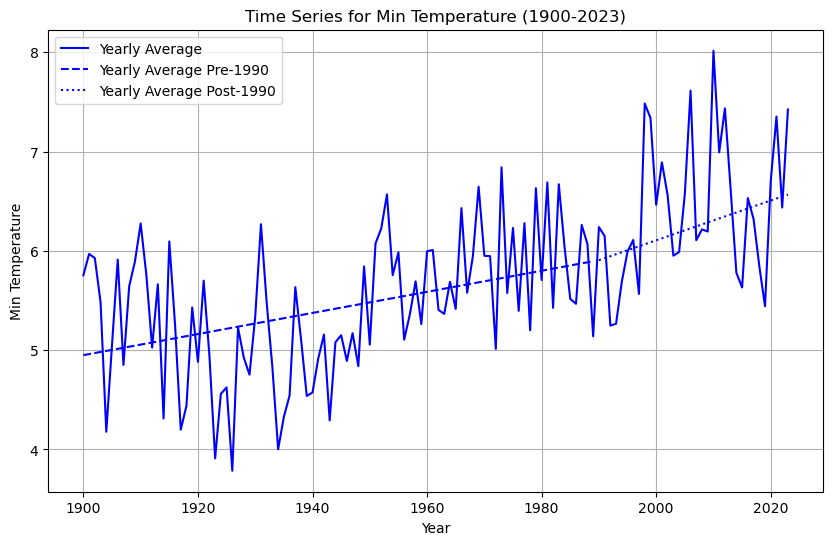

Yearly Average Pre-1990 Gradient (Slope): 0.005526
Yearly Average Pre-1990 Z-Score: 2.689739
Yearly Average Post-1990 Gradient (Slope): 0.015532
Yearly Average Post-1990 Z-Score: 1.364540


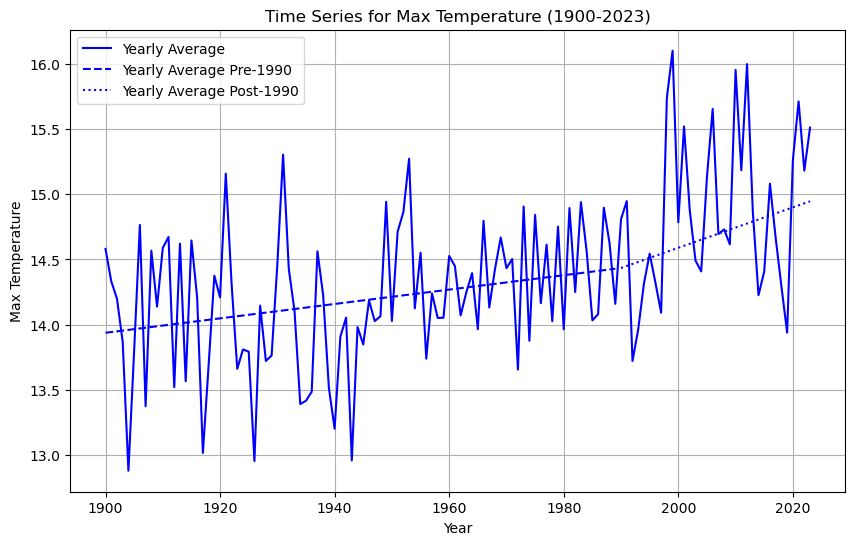

Yearly Average Pre-1990 Gradient (Slope): 0.163024
Yearly Average Pre-1990 Z-Score: 6.916760
Yearly Average Post-1990 Gradient (Slope): -0.191221
Yearly Average Post-1990 Z-Score: -1.259075


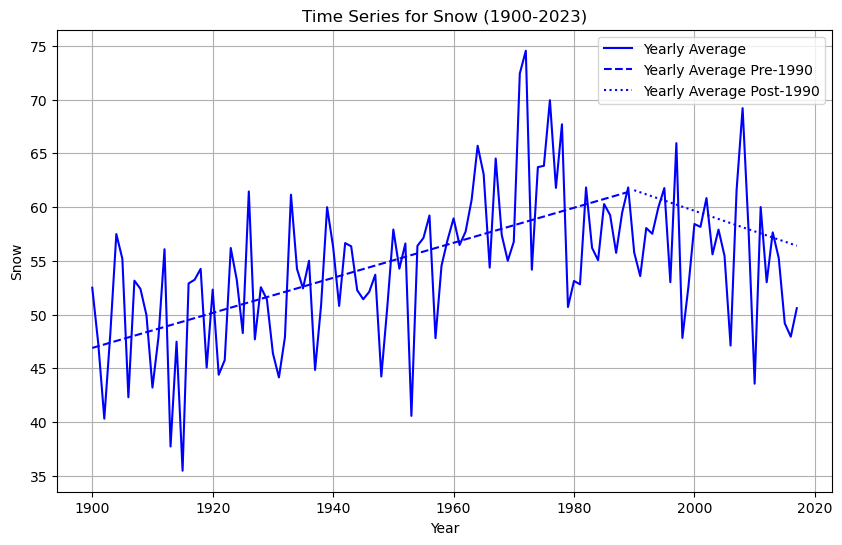

Yearly Average Pre-1990 Gradient (Slope): 0.006820
Yearly Average Pre-1990 Z-Score: 0.156305
Yearly Average Post-1990 Gradient (Slope): 0.050988
Yearly Average Post-1990 Z-Score: 0.156429


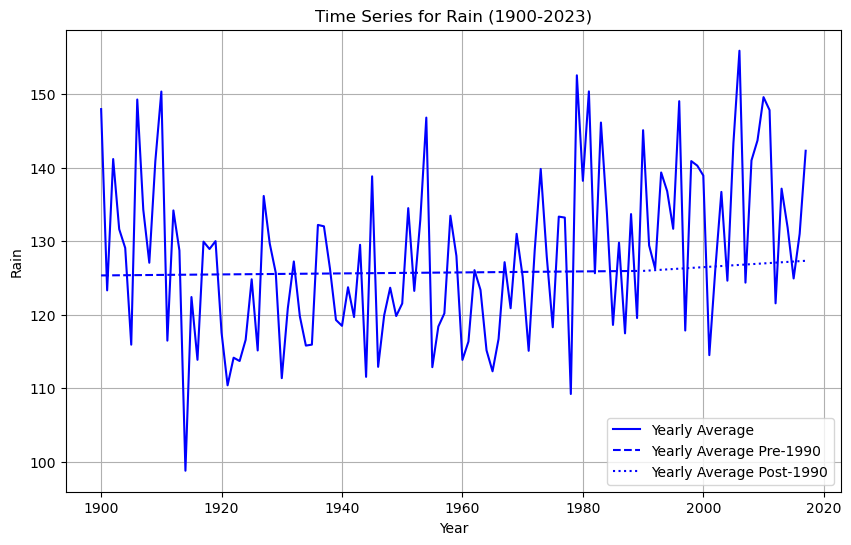

Yearly Average Pre-1990 Gradient (Slope): 0.138494
Yearly Average Pre-1990 Z-Score: 3.122816
Yearly Average Post-1990 Gradient (Slope): -0.117946
Yearly Average Post-1990 Z-Score: -0.428852


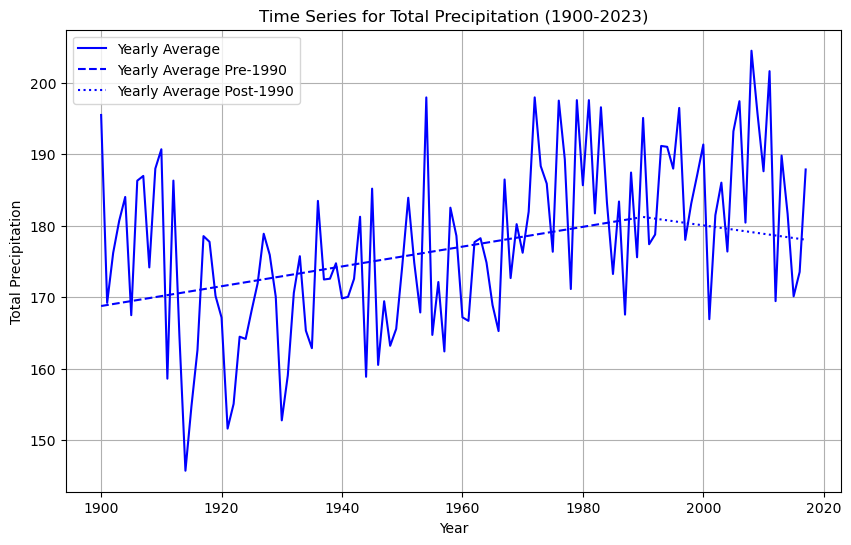

Yearly Average Pre-1990 Gradient (Slope): 0.023516
Yearly Average Pre-1990 Z-Score: 2.122685
Yearly Average Post-1990 Gradient (Slope): -0.028720
Yearly Average Post-1990 Z-Score: -1.619347


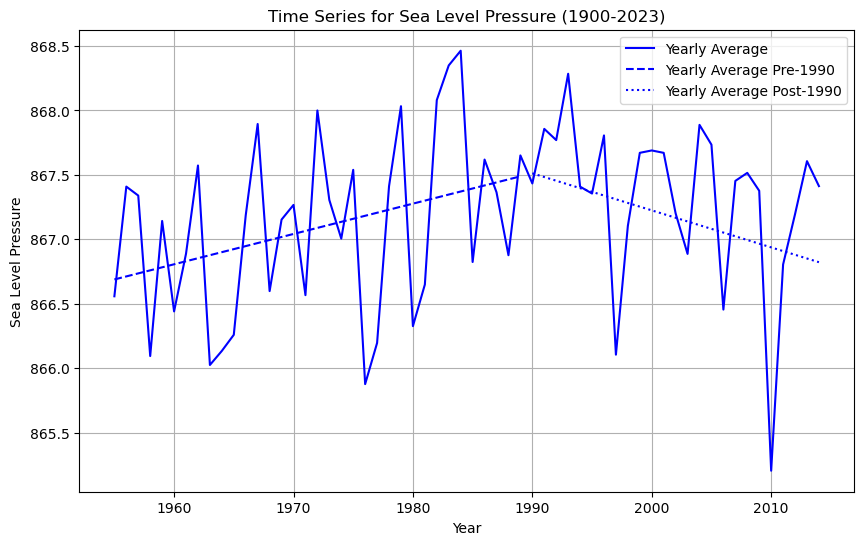

Yearly Average Pre-1990 Gradient (Slope): -0.037180
Yearly Average Pre-1990 Z-Score: -1.886415
Yearly Average Post-1990 Gradient (Slope): 0.017393
Yearly Average Post-1990 Z-Score: 0.576295


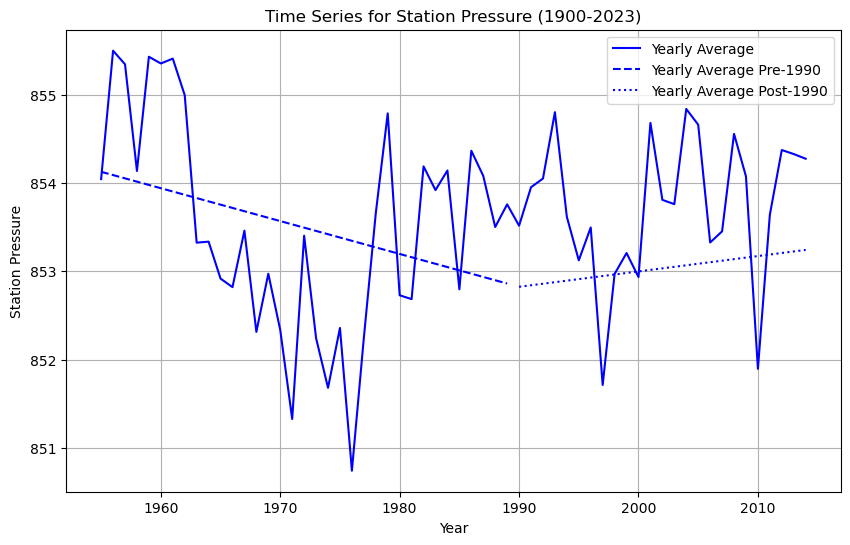

Yearly Average Pre-1990 Gradient (Slope): -0.025385
Yearly Average Pre-1990 Z-Score: -6.028532
Yearly Average Post-1990 Gradient (Slope): -0.007127
Yearly Average Post-1990 Z-Score: -0.559561


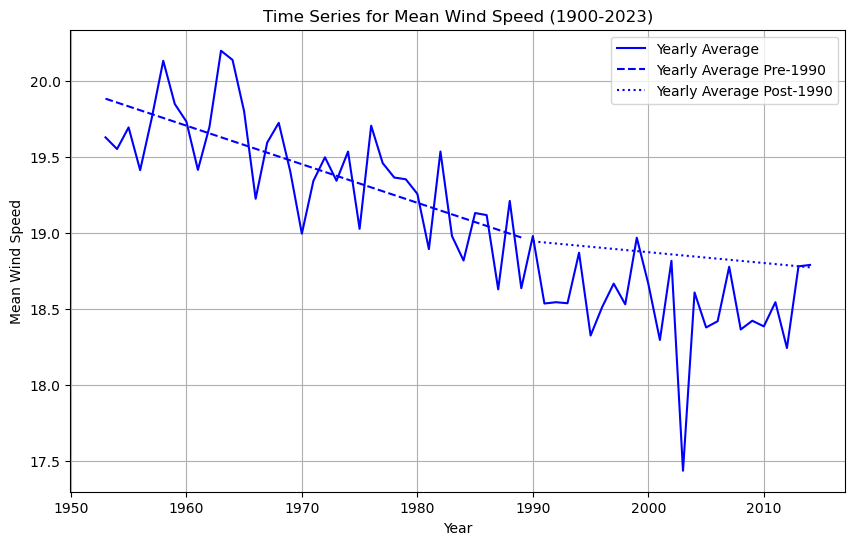

Yearly Average Pre-1990 Gradient (Slope): 0.007953
Yearly Average Pre-1990 Z-Score: 3.539990
Yearly Average Post-1990 Gradient (Slope): 0.017751
Yearly Average Post-1990 Z-Score: 1.493629


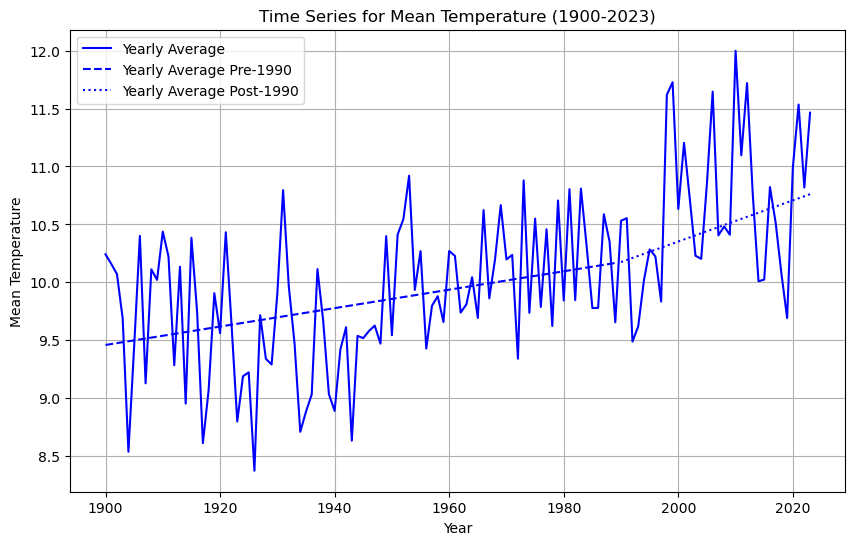

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ecws_data = pd.read_csv('AHCCD_CONFINED.csv')
ecws_data['Year'] = pd.to_numeric(ecws_data['Year'], errors='coerce')
ecws_data = ecws_data.dropna(subset=['Year'])

start_year = 1900
end_year = 2023
split_year = 1990

variable_types = ecws_data['Value Type'].unique()

def plot_with_connected_regression(time, data, color, label, split_year):
    plt.plot(time, data, color=color, label=label)

    pre_1990_indices = time < split_year
    time_pre1990 = time[pre_1990_indices]
    data_pre1990 = data[pre_1990_indices]
    coeffs_pre1990 = np.polyfit(time_pre1990, data_pre1990, 1)
    slope_pre1990, intercept_pre1990 = coeffs_pre1990
    y_fit_pre1990 = np.polyval(coeffs_pre1990, time_pre1990)
    plt.plot(time_pre1990, y_fit_pre1990, color=color, linestyle='--', label=f'{label} Pre-{split_year}')

    residuals_pre1990 = data_pre1990 - y_fit_pre1990
    s_err_pre1990 = np.sqrt(np.sum(residuals_pre1990**2) / (len(time_pre1990) - 2))
    x_mean_pre1990 = np.mean(time_pre1990)
    se_slope_pre1990 = s_err_pre1990 / np.sqrt(np.sum((time_pre1990 - x_mean_pre1990)**2))
    z_score_pre1990 = slope_pre1990 / se_slope_pre1990

    print(f"{label} Pre-{split_year} Gradient (Slope): {slope_pre1990:.6f}")
    print(f"{label} Pre-{split_year} Z-Score: {z_score_pre1990:.6f}")

    post_1990_indices = time >= split_year
    time_post1990 = time[post_1990_indices]
    data_post1990 = data[post_1990_indices]
    slope_post1990, _ = np.polyfit(time_post1990, data_post1990, 1)

    intercept_post1990 = slope_pre1990 * split_year + intercept_pre1990 - slope_post1990 * split_year
    y_fit_post1990 = slope_post1990 * time_post1990 + intercept_post1990
    plt.plot(time_post1990, y_fit_post1990, color=color, linestyle=':', label=f'{label} Post-{split_year}')

    residuals_post1990 = data_post1990 - y_fit_post1990
    s_err_post1990 = np.sqrt(np.sum(residuals_post1990**2) / (len(time_post1990) - 2))
    x_mean_post1990 = np.mean(time_post1990)
    se_slope_post1990 = s_err_post1990 / np.sqrt(np.sum((time_post1990 - x_mean_post1990)**2))
    z_score_post1990 = slope_post1990 / se_slope_post1990

    print(f"{label} Post-{split_year} Gradient (Slope): {slope_post1990:.6f}")
    print(f"{label} Post-{split_year} Z-Score: {z_score_post1990:.6f}")

for var_type in variable_types:
    data_subset = ecws_data[ecws_data['Value Type'] == var_type]
    data_subset = data_subset[(data_subset['Year'] >= start_year) & (data_subset['Year'] <= end_year)]
    
    yearly_avg = data_subset.groupby('Year').mean(numeric_only=True).reset_index()
    X = yearly_avg['Year'].values
    y = yearly_avg.iloc[:, 1:].mean(axis=1).values
    
    plt.figure(figsize=(10, 6))
    plot_with_connected_regression(X, y, 'blue', 'Yearly Average', split_year)
    plt.title(f'Time Series for {var_type} ({start_year}-{end_year})')
    plt.xlabel('Year')
    plt.ylabel(var_type)
    plt.legend()
    plt.grid()
    plt.show()


